# Time Series Analysis of the Standard and Poor's (S&P) 500 Index

#### Daphka Alius
#### April 15, 2019

ime series is a sequence of observations taken at discrete intervals in time. Time series analysis can be used to model data and is particularly useful in stock market analysis. The observations over a period of time can be mined for powerful insights that are useful in forecasting and predicting future observations. After a first introduction to the topic, I performed a time series analysis of the S&P 500 monthly dataset from January 1997 - December 2017 with a series of python libraries to forecast the 2018 monthly prices. In taking these steps, my goals were to gain a further understanding of the methodologies and build an intuition for how to interpret the results. I will employ different python modules and libraries including Pandas, NumPy, and statsmodels to complete the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import thinkplot
import thinkstats2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
path = "/Users/daphka/Desktop/^GSPC.csv"

## Loading Data

Reading the CSV file into a Pandas DataFrame and converting the Date column into a datetime object.

In [3]:
SP500 = pd.read_csv(path, parse_dates =[0], index_col=0)

The columns of the data set are:

+ **Open:** The price of a stock at opening
+ **High:** Highest recorded trading price of the day
+ **Low:** Lowest recorded trading price of the day
+ **Adj Close:** Amended closing price of the day
+ **Volume:** Number of stocks traded on this day

The data is the monthly return of the S&P500 dating from 1/1/1997 to 12/1/2018.

In [4]:
SP500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-01,740.739990,794.669983,729.549988,786.159973,786.159973,11635830000
1997-02-01,786.159973,817.679993,773.429993,790.820007,790.820007,9715930000
1997-03-01,790.820007,814.900024,756.130005,757.119995,757.119995,10120760000
1997-04-01,757.119995,804.130005,733.539978,801.340027,801.340027,10454880000
1997-05-01,801.340027,851.869995,793.210022,848.280029,848.280029,10106650000


In [5]:
SP500.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,2821.169922,2916.500000,2796.340088,2901.520020,2901.520020,69238220000
2018-09-01,2896.959961,2940.909912,2864.120117,2913.979980,2913.979980,62492080000
2018-10-01,2926.290039,2939.860107,2603.540039,2711.739990,2711.739990,91327930000
2018-11-01,2717.580078,2815.149902,2631.090088,2760.169922,2760.169922,80080110000
2018-12-01,2790.500000,2800.179932,2346.580078,2506.850098,2506.850098,83519570000


Here's a the preliminary statistics summary of the variables.

In [6]:
SP500.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,264.0,1.444534e+03,5.012407e+02,7.295700e+02,1.110695e+03,1.302360e+03,1.615263e+03,2.926290e+03
High,264.0,1.489961e+03,5.060851e+02,7.946700e+02,1.146042e+03,1.342175e+03,1.690080e+03,2.940910e+03
Low,264.0,1.394649e+03,4.927820e+02,6.667900e+02,1.074600e+03,1.257845e+03,1.587103e+03,2.864120e+03
Close,264.0,1.450407e+03,5.021138e+02,7.350900e+02,1.111878e+03,1.302830e+03,1.631297e+03,2.913980e+03
Adj Close,264.0,1.450407e+03,5.021138e+02,7.350900e+02,1.111878e+03,1.302830e+03,1.631297e+03,2.913980e+03
Volume,264.0,5.753797e+10,3.251090e+10,9.715930e+09,2.737350e+10,6.408518e+10,7.970272e+10,1.618436e+11


## Variable of Interest: Adj Close

Adj Close is short for adjusted closing price. The adjusted closing price of the index refers to the closing price of the stock amended to any corporate actions that may have influenced the stock price for that day.

I will be using data from 1/1/1997-12/31/2017 to extract information to build a model to forecast the 2018 monthly returns.

In [61]:
prices = SP500["Adj Close"][:-12]

In [62]:
len(prices)

252

In [8]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("dark")



## Exploratory Analysis

Here's a plot of the adjusted closing price over the past 20 years.

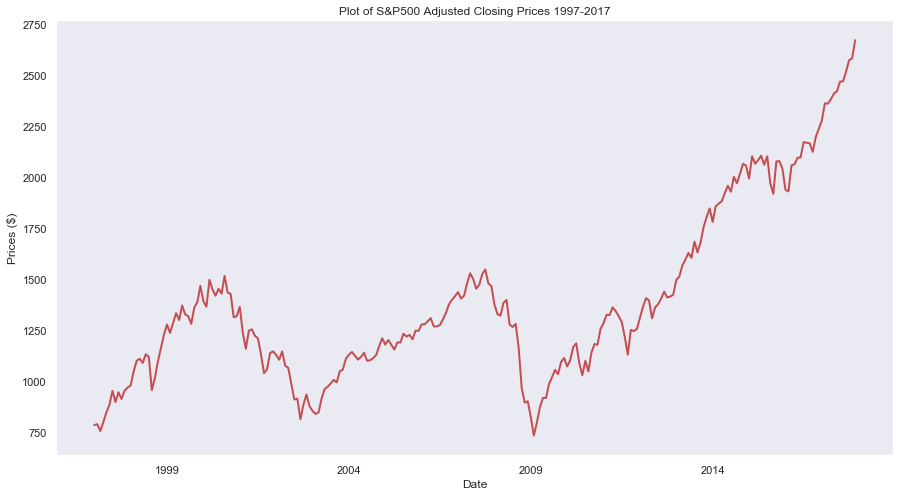

In [9]:
prices.plot(linewidth=2, c="r");
plt.ylabel('Prices ($)')
plt.title('Plot of S&P500 Adjusted Closing Prices 1997-2017')
plt.savefig("adjclose.png", bbox_inches="tight", ext="png")
plt.show()

Any time series analysis is based on the assumption that the observations have the following three components:

+ Trend - captures long-term changes
+ Seasonality - captures periodic variations in the data
+ Noise - random variation of the trend

Trend and seasonality are great indicators of a property known as stationarity. A data is considered stationary if all the observations are from the same distribution. In other words, a time series is stationary if the mean, variance, and correlation are constant over time. Stationarity is an important property when building a model because most models do not account for the trend. If the time series is non-stationary, then it must be transformed to stationary.

In order to determine if the data is stationary or non-stationary, we have to see if there's any trend or seasonality.

**Trend:** Based on the plot, it seems that the  adjusted closing price has been increasing over the past 20 years. However, we can use a rolling mean to smoothen out this pattern. A rolling mean is a statistical tool used to smoothen short-term fluctuations in the data set in order to highlight long-term trends.

#### Testing for trend using a rolling mean

Here I used a rolling mean with a window size = 12 to capture yearly data. I've also calculated the rolling standard deviation to see if there's any volatility.

In [10]:
rollingMean = prices.rolling(12).mean()
rollingStd = prices.rolling(12).std()

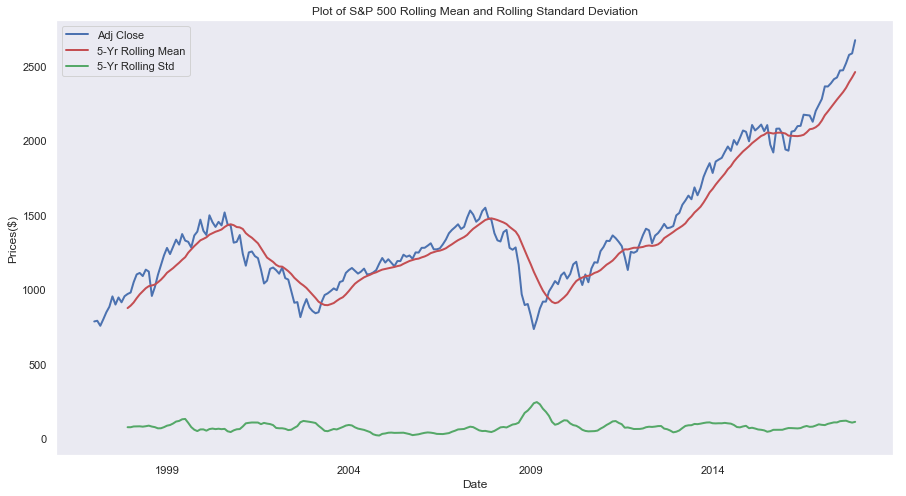

In [11]:
prices.plot(linewidth=2)
rollingMean.plot(label = "5-Yr Rolling Mean", linewidth=2, c="r")
rollingStd.plot(label = "5-Yr Rolling Std", linewidth=2, c="g")
plt.ylabel("Prices($)")
plt.title("Plot of S&P 500 Rolling Mean and Rolling Standard Deviation")
plt.legend()
plt.savefig("rollingmean.png", bbox_inches="tight", ext="png")
plt.show()

Based on this plot, it shows an increasing pattern over the 20 years period. However, there's a lot of variation in the observations. A statistical tool, known as a *rolling mean* can be used to smoothen out the short-term fluctuations in the data in order to highlight long-term trends. Here I use a window of 12 months, which means that the function selects on a rolling basis a 12 month interval to calculate the mean. I've also calculated the rolling standard deviation to see if there's any volatility.

#### Can the mean and standard deviation tell us more?

Another method to test stationary is to look at the mean and standard deviation.

Here I partition the data into 4 sets of equal width and compute the summary statistics like mean and variance to see if the data is consistent through out each partition.

In [12]:
split = int(len(prices)/4)
part1, part2, part3, part4 = prices.values[:split], prices.values[split: 2*split], prices.values[2*split: 3*split], prices.values[3*split:]

In [85]:
mean1, mean2, mean3, mean4 = part1.mean(), part2.mean(), part3.mean(), part4.mean()
std1, std2, std3, std4 = part1.std(), part2.std(), part3.std(), part4.std()
df_stats = pd.DataFrame()
df_stats["Mean"] = [mean1, mean2, mean3, mean4]
df_stats["Standard Deviation"] = [std1, std2, std3, std4]

In [86]:
df_stats.transpose()

,0,1,2,3
Mean,1177.487296,1155.503010,1210.167297,2013.139210
Standard Deviation,198.679406,176.692252,193.331258,300.492076


The results of this procedure show that the mean and variance is not consistent across all partition, which is another sign that this data set is non-stationary.

#### Using statsmodels time series module to decompose the dataset

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

statsmodels provide a method called **seasonal_decompose** which breaks down your time series into its three components:
1. Trend
2. Seasonality
3. Noise

In [16]:
decomposition = seasonal_decompose(prices)

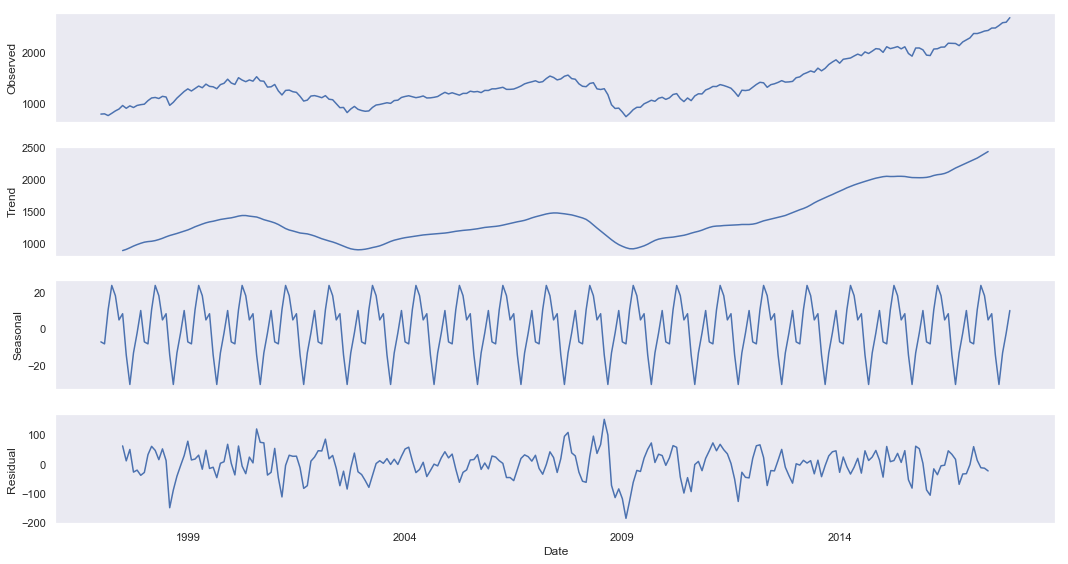

In [17]:
fig = decomposition.plot()
plt.savefig("decomposition.png", bbox_inches="tight", ext="png")

This method returns three plots for trend, seasonality, and noise. From the plot above, it is clear that there's an increasing trend.  There seems to be some **seasonality** which was not obvious from just plotting the data. This tool graphically provide a preliminary test of stationarity. However, there is an even more robust test of stationarity called the Augmented Dickey-Fuller Test which can also be accessed via statsmodels time series analysis tools.

### Augmented Dickey-Fuller Test for Stationarity

Simplistically, the Augmented Dickey-Fuller Test for Stationarity is a statistical test known as a unit root test. A unit root test defines how strongly a time series is defined by its trend. The null hypothesis is that a time series can be represented by a unit root, which would imply that the variable is non-stationary. The alternate hypothesis in this case would be the negation - that it is stationary. Therefore, if we find a large p-value from this test, then we can determine that our variable is non-stationary and a smaller p-value would indicate stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.statespace.tools import diff

In [19]:
adf_result = adfuller(prices)

In [21]:
print("ADF Statistics: {}, p-value: {}".format(adf_result[0], adf_result[1]))
for key, value in adf_result[4].items():
    print(key, value)

ADF Statistics: 0.8076504166249344, p-value: 0.9917586617863505
1% -3.4566744514553016
5% -2.8731248767783426
10% -2.5729436702592023


Given such a high p-value, the result suggests that it is highly likely that this time series does have a unit root which confirms that the time series data is indeed non-stationary.Therefore, I will need to transform it to stationary in order to estimate the parameters of the forecasting model.

## Estimating a Model for Forecasting

We've been looking at trend and seasonality to determine whether our data is stationary or not, we can also look at the correlation between the observations to see if it constant. 

In order to build a model for forecasting, it is crucial to know how much to transform and adjust our variable in order to make it stationary. This is why we will use the Autocorrelation function to see how much differencing we need to transform the data to stationary.

### Autocorrelation Function (ACF)

Time Series data have the property that the observations are ordered which means that past values can help us predict future values based on the correlation between each observations. The Autocorrelation Function (ACF) plots the coefficients of correlation between a time series and a shifted version of itself. In simpler terms, the *ACF* provides insights on how points in the data are correlated separated by a specific lag time. A **lag** is an interval used to calculate the correlation. For example, when lag = 1, the function calculates the correlation between values at *t=0* with *t=1*, *t=1* with *t=2*, *...*, and *t=n-1* with *t=n*.

### Using the statsmodels plot_acf module to plot the ACF

This model works under the following assumptions:
1. lag = 40 and 
2. alpha = 0.05, which means that it plots the 95% confidence interval.

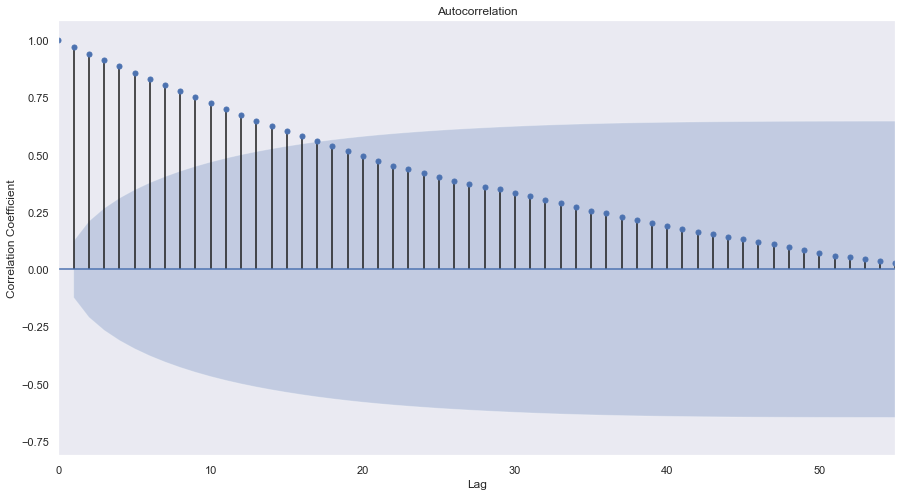

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(prices)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.xlim(0, 55)
plt.savefig("acf1.png", bbox_inches="tight", ext="png")
plt.show()


As is expected, we see that our correlation is not constant across different lags since we have shown that this variable is non-stationary. 

### Transforming Data into Stationary by Taking the Differences

This function transforms the data using a lag of order 1 (d = 1) by default, which means that it computes the autocorrelation of one value with the consecutive value.

In [23]:
prices_diff = diff(prices)

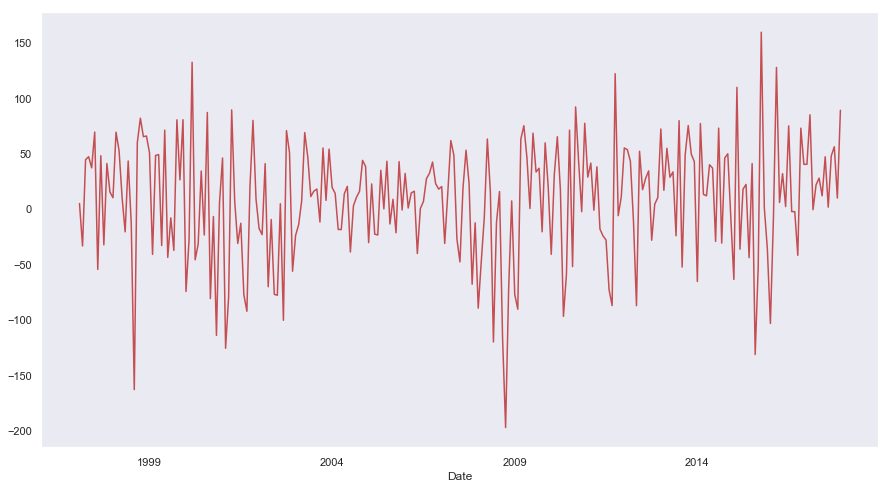

In [24]:
prices_diff.plot(c="r")
plt.savefig("transformed_adjclose.png", bbox_inches="tight", ext="png")
plt.show()

Now, I will plot this transformed data using the plot_acf function of statsmodels

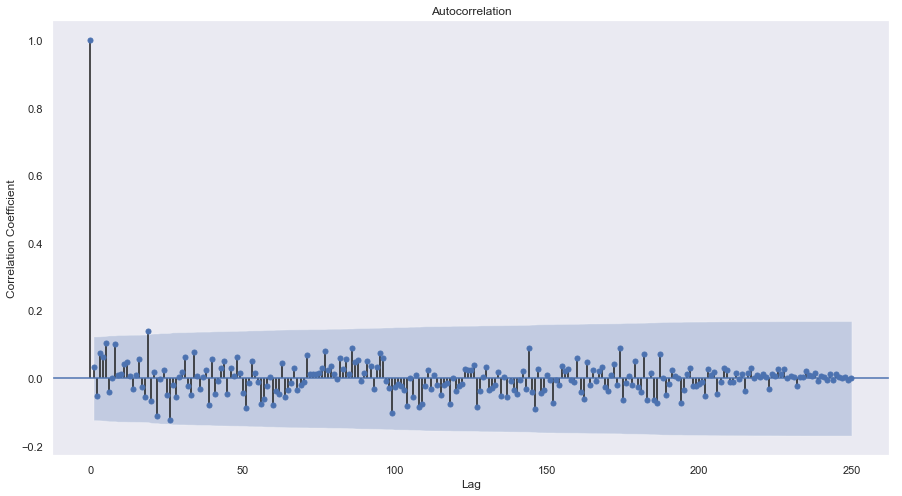

In [87]:
plot_acf(prices_diff)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.savefig("transformed_acf", bbox_inches="tight", ext="png")
plt.show()

In [88]:
adf_result_diff = adfuller(prices_diff)

In [89]:
print("ADF Statistics for Prices Diff: {}, p-value: {}".format(adf_result_diff[0], adf_result_diff[1]))
for key, value in adf_result_diff[4].items():
    print(key, value)

ADF Statistics for Prices Diff: -15.155031303806982, p-value: 6.7134196574358405e-28
1% -3.456780859712
5% -2.8731715065600003
10% -2.572968544


Observe that the value of the adf test is strongly negative and the p-value is significantly smaller than before which means we can assume that our model has been transformed from non-stationary to stationary. Now we will employ the ARIMA model to forecast the next years adjusted return prices.

**ARIMA MODEL**

ARIMA stands for Autoregressive Integrated Moving Average.

+ Autoregression (*p*)- refers to the dependent relationship between an observation and some number of lagged observation
+ Integrated (*d*)- refers to the difference of the raw observations (i.e the shifting required to transform observations to make time series stationary)
+ Moving Average (*q*) - a succession of averages derived from successive segments

These three components are the parameters  used to create the model. statsmodels provides an ARIMA function which creates the model with the parameters *p, d, q*. To create a model for the S&P 500 data, I use the parameter p = 1, d = 1, and q = 0 . I estimate p = 1 because the data is highly correlated to itself as was seen from the ACF plot and d = 1 since it was sufficient to transform the data from non-stationary to stationary.


In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
arima_results = ARIMA(prices, order=(1, 1, 0))

/Users/daphka/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/daphka/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [30]:
model_fit = arima_results.fit()

/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

In [75]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1355.005
Method:                       css-mle   S.D. of innovations             53.489
Date:                Thu, 11 Apr 2019   AIC                           2716.009
Time:                        17:09:35   BIC                           2726.585
Sample:                    02-01-1997   HQIC                          2720.265
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5305      3.493      2.156      0.032       0.684      14.377
ar.L1.D.Adj Close     0.0336      0.063      0.531      0.596      -0.090       0.158
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           29.7600           +0.0000j           29.7600            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
resid = model_fit.resid

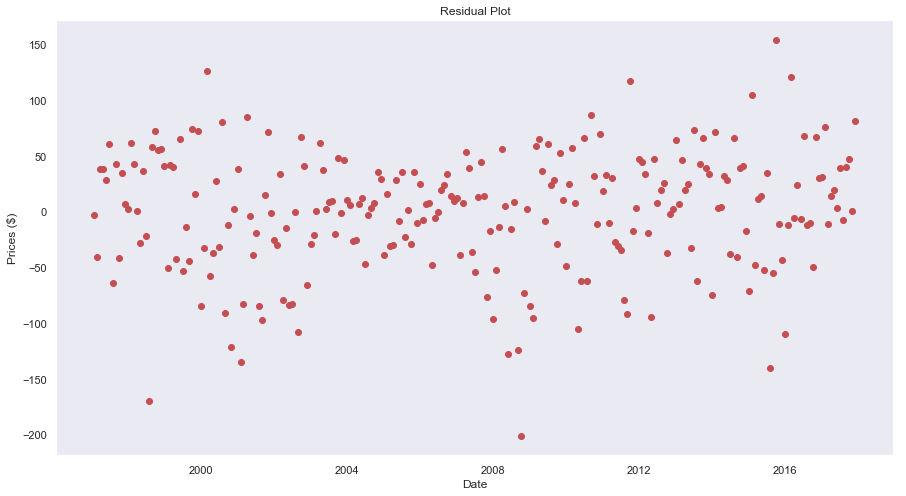

In [76]:
plt.plot(resid, 'o', c='r')
plt.title("Residual Plot")
plt.xlabel("Date")
plt.ylabel("Prices ($)")
plt.savefig("residuals.png", bbox_inches="tight", ext="png")
plt.show()

In [34]:
resid.describe()

count    251.000000
mean       0.000463
std       53.596278
min     -200.973792
25%      -31.128287
50%        5.399341
75%       36.808593
max      153.804979
dtype: float64

In [35]:
from thinkstats2 import Cdf

In [36]:
resid_cdf = Cdf(resid)

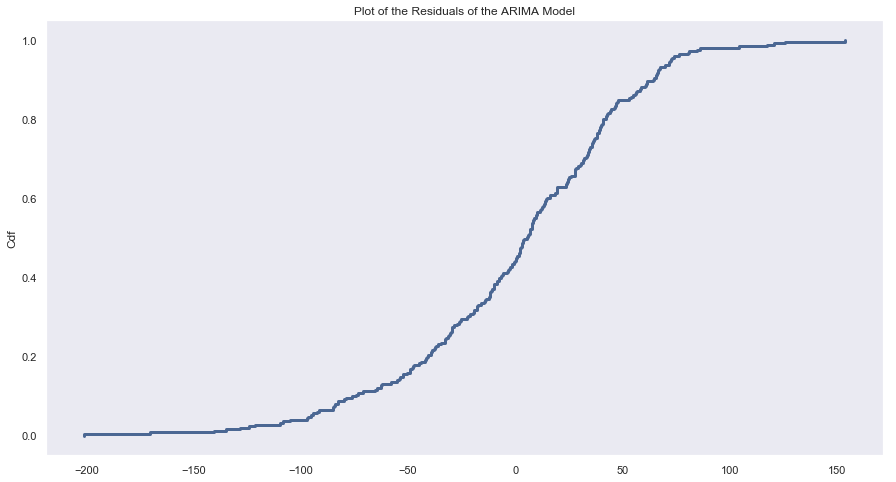

In [37]:
thinkplot.Cdf(resid_cdf)
plt.ylabel("Cdf")
plt.title("Plot of the Residuals of the ARIMA Model")
plt.savefig("residual_cdf.png", bbox_inches="tight", ext="png")
plt.show()

In [38]:
result = model_fit.forecast(steps=12)

The plot shows the residuals with a mean of 0 clustering around the horizontal axis for the most part which means that the model was potentially a good fit.

In [41]:
prices_2 = prices.copy()

In [43]:
i=0
for date in time_2018:
    prices_2[date] = result[0][i]
    i+=1


In [40]:
time_2018 = pd.date_range(start="1/1/2018", end="12/31/2018", freq="MS")

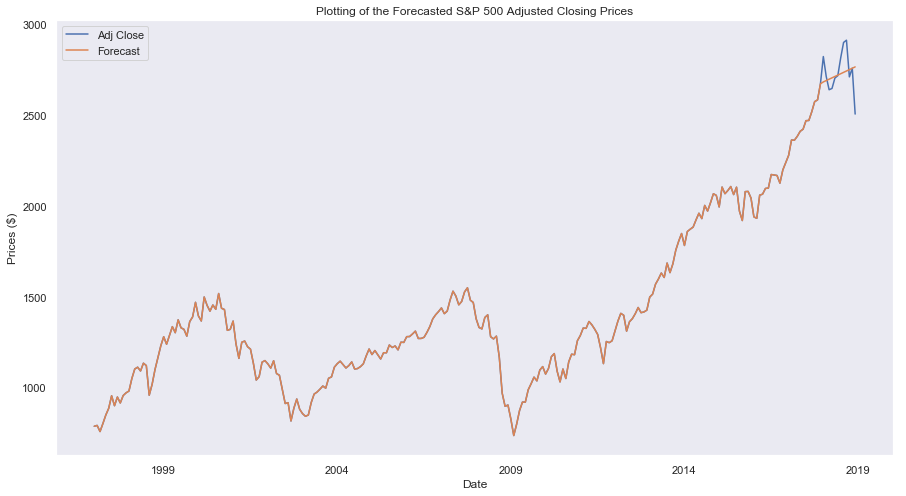

In [45]:
SP500["Adj Close"].plot()
prices_2.plot(label="Forecast")
plt.title("Plotting of the Forecasted S&P 500 Adjusted Closing Prices")
plt.ylabel("Prices ($)")
plt.legend()
plt.savefig("forecast.png", bbox_inches="tight", ext="png")
plt.show()

In [83]:

result_df = pd.DataFrame()
result_df["EXPECTED"] = SP500["Adj Close"][-12:]
result_df["FORECAST"] = prices_2[-12:]
result_df

,EXPECTED,FORECAST
Date,,
2018-01-01,2823.810059,2683.870430
2018-02-01,2713.830078,2691.492655
2018-03-01,2640.870117,2699.026234
2018-04-01,2648.050049,2706.556834
2018-05-01,2705.270020,2714.087333
2018-06-01,2718.370117,2721.617830
2018-07-01,2816.290039,2729.148326
2018-08-01,2901.520020,2736.678823
2018-09-01,2913.979980,2744.209319


In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
print("MSE",mean_squared_error(SP500["Adj Close"][-12:], prices_2[-12:]))

MSE 13311.589441622107


Another calculation for how well the model fit the data is the root mean squared error. It can be interpreted as the standard deviation of the unexplained variance and is expressed in the same terms as the dependent variable. In this case the root mean error of the actual 2018 monthly values is approximately $13,311. Evaluating the plot for the actual prices and the forecasted prices, there's a high deviation between the two segments. There are many factors that could have impacted the actual prices that caused this deviation including political and economic factors that the model does not consider. However, it's worth considering performing this analysis with a different set of parameters to see if there's a better fit.